# Zadanie 6 — PINN dla PDE (porównanie z PDE i ODE)

Cel:
1) Stworzyć fizycznie informowaną sieć (PINN) aproksymującą pola S(x,y,t), R(x,y,t), I(x,y,t), C(x,y,t).
2) Trenować PINN na:
   - resztach równań PDE (fizyka),
   - warunkach początkowych i brzegowych,
   - słabych danych TB(t)=∬(S+R) dxdy z PDE (po asymilacji).
3) Porównać predykcję PINN z symulacją PDE oraz z modelem ODE (parametry z asymilacji).
Zapisy: figi → `figs/`, dane → `out/`.

In [1]:
import os, json, math, time, random, sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Path("figs").mkdir(exist_ok=True)
Path("out").mkdir(exist_ok=True)

def savefig_fig(name, dpi=160):
    if not str(name).startswith("figs/"):
        name = f"figs/{name}"
    plt.savefig(name, dpi=dpi, bbox_inches="tight")
    print(f"[Zapisano wykres] {name}")

def save_json(obj, path):
    if not str(path).startswith("out/"):
        path = f"out/{path}"
    with open(path, "w") as f:
        json.dump(obj, f, indent=2)
    print(f"[Zapisano JSON] {path}")

# Reproducowalność
np.random.seed(123)
random.seed(123)

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "mps")
device

device(type='cuda')

In [ ]:
# === PATCH 1: normalizacja wejść i skale wyjść (do PINN) ===
# Jeśli nie masz Lx/Ly w kodzie, ustaw 1.0 (domena jednostkowa).
try:
    Lx = float(Lx)
    Ly = float(Ly)
except NameError:
    Lx, Ly = 1.0, 1.0

# Mapowanie wejść: t ∈ [0, T_end] → [0,1], x,y ∈ [0,L] → [-1,1]
def norm_inputs(t, x, y):
    tn = t / T_end
    xn = 2.0 * (x / Lx) - 1.0
    yn = 2.0 * (y / Ly) - 1.0
    return tn, xn, yn

# Zgrubne skale wyjść zgodne z rzędem wielkości z Twoich symulacji PDE
OUT_SCALE = {
    "S": 1e-3,   # ~1e-3
    "R": 1e-2,   # ~1e-2
    "I": 2e-2,   # ~2e-2
    "C": 1.0     # ~1
}


[Zapisano trajektorię] out/explicit_Nx96_Ny96_traj.csv
[Zapisano metadane] out/explicit_Nx96_Ny96_info.json
[Zapisano macierz] out/explicit_Nx96_Ny96_S_final.npy
[Zapisano macierz] out/explicit_Nx96_Ny96_R_final.npy
[Zapisano macierz] out/explicit_Nx96_Ny96_I_final.npy
[Zapisano macierz] out/explicit_Nx96_Ny96_C_final.npy
[Zapisano wykres] figs/explicit_S_final.png
[Zapisano wykres] figs/explicit_R_final.png
[Zapisano wykres] figs/explicit_I_final.png
[Zapisano wykres] figs/explicit_C_final.png
[Zapisano trajektorię] out/semi_implicit_Nx96_Ny96_traj.csv
[Zapisano metadane] out/semi_implicit_Nx96_Ny96_info.json
[Zapisano macierz] out/semi_implicit_Nx96_Ny96_S_final.npy
[Zapisano macierz] out/semi_implicit_Nx96_Ny96_R_final.npy
[Zapisano macierz] out/semi_implicit_Nx96_Ny96_I_final.npy
[Zapisano macierz] out/semi_implicit_Nx96_Ny96_C_final.npy
[Zapisano wykres] figs/semi_implicit_S_final.png
[Zapisano wykres] figs/semi_implicit_R_final.png
[Zapisano wykres] figs/semi_implicit_I_final.png

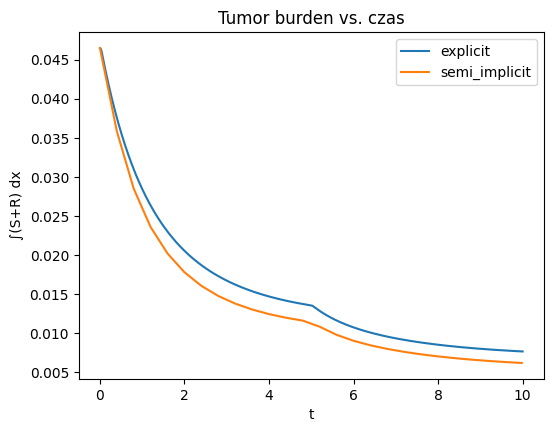

[explicit] N=64  dt=9.070e-04  time=2.25s  TB=0.01344
[semi_implicit] N=64  dt=2.000e-02  time=3.24s  TB=0.01149
[explicit] N=96  dt=3.989e-04  time=8.20s  TB=0.01357
[semi_implicit] N=96  dt=2.000e-02  time=9.96s  TB=0.01149
[explicit] N=128  dt=2.232e-04  time=16.91s  TB=0.01358
[semi_implicit] N=128  dt=2.000e-02  time=13.31s  TB=0.01149
[Zapisano] out/benchmark_resolutions.csv
[Zapisano wykres] figs/benchmark_time_vs_N.png


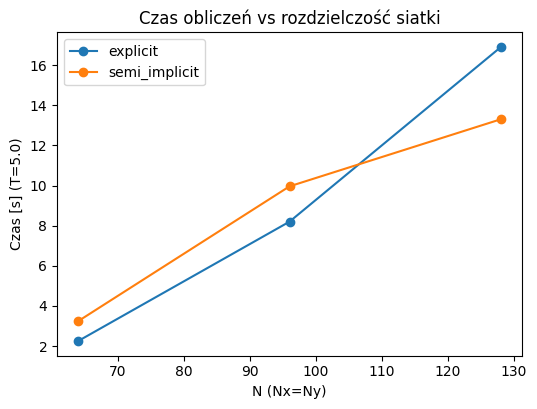

[explicit] dt=1.008e-03 steps=4962 time=1.25s
[explicit] dt=6.719e-04 steps=7442 time=1.93s
[explicit] dt=5.039e-04 steps=9923 time=2.52s
[explicit] dt=3.359e-04 steps=14884 time=3.84s
[Zapisano wykres] figs/stability_vs_dt_explicit.png


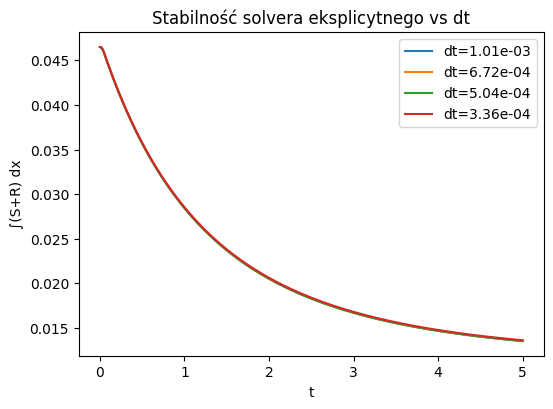

D_C=0.005 -> TB_final=0.01149 (solver=semi_implicit, dt=2.000e-02)
D_C=0.01 -> TB_final=0.01149 (solver=semi_implicit, dt=2.000e-02)
D_C=0.02 -> TB_final=0.01149 (solver=semi_implicit, dt=2.000e-02)
D_C=0.03 -> TB_final=0.01149 (solver=semi_implicit, dt=2.000e-02)
alpha_S=0.4 -> TB_final=0.01855 (solver=semi_implicit, dt=2.000e-02)
alpha_S=0.8 -> TB_final=0.01149 (solver=semi_implicit, dt=2.000e-02)
alpha_S=1 -> TB_final=0.01027 (solver=semi_implicit, dt=2.000e-02)
alpha_S=1.2 -> TB_final=0.00962 (solver=semi_implicit, dt=2.000e-02)
mu_max=0 -> TB_final=0.01016 (solver=semi_implicit, dt=2.000e-02)
mu_max=0.02 -> TB_final=0.01071 (solver=semi_implicit, dt=2.000e-02)
mu_max=0.05 -> TB_final=0.01149 (solver=semi_implicit, dt=2.000e-02)
mu_max=0.1 -> TB_final=0.01268 (solver=semi_implicit, dt=2.000e-02)
[Zapisano] out/param_sweep_basic.csv
[Zapisano wykres] figs/param_Dc_tb.png


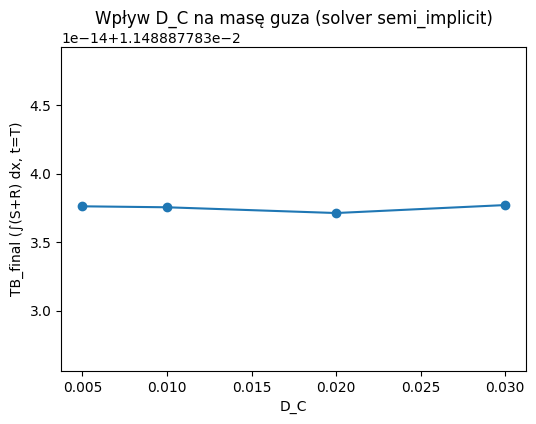

[Zapisano wykres] figs/param_alphaS_tb.png


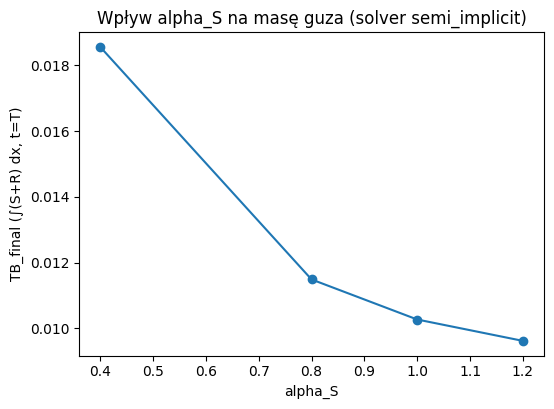

[Zapisano wykres] figs/param_mu_tb.png


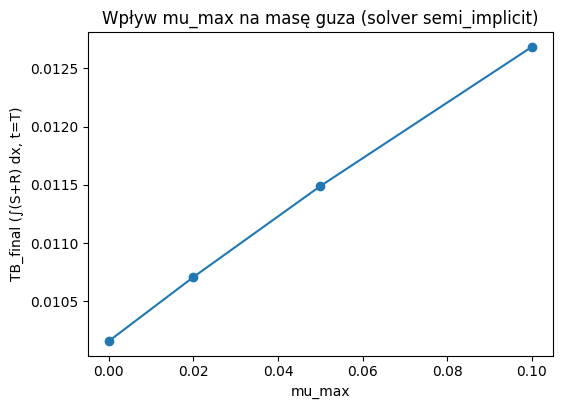

[Zapisano trajektorię] out/compare_explicit_N96_traj.csv
[Zapisano metadane] out/compare_explicit_N96_info.json
[Zapisano macierz] out/compare_explicit_N96_S_final.npy
[Zapisano macierz] out/compare_explicit_N96_R_final.npy
[Zapisano macierz] out/compare_explicit_N96_I_final.npy
[Zapisano macierz] out/compare_explicit_N96_C_final.npy
[Zapisano wykres] figs/compare_explicit_S_final.png
[Zapisano wykres] figs/compare_explicit_R_final.png
[Zapisano wykres] figs/compare_explicit_I_final.png
[Zapisano wykres] figs/compare_explicit_C_final.png
[Zapisano trajektorię] out/compare_semi_implicit_N96_traj.csv
[Zapisano metadane] out/compare_semi_implicit_N96_info.json
[Zapisano macierz] out/compare_semi_implicit_N96_S_final.npy
[Zapisano macierz] out/compare_semi_implicit_N96_R_final.npy
[Zapisano macierz] out/compare_semi_implicit_N96_I_final.npy
[Zapisano macierz] out/compare_semi_implicit_N96_C_final.npy
[Zapisano wykres] figs/compare_semi_implicit_S_final.png
[Zapisano wykres] figs/compare_se

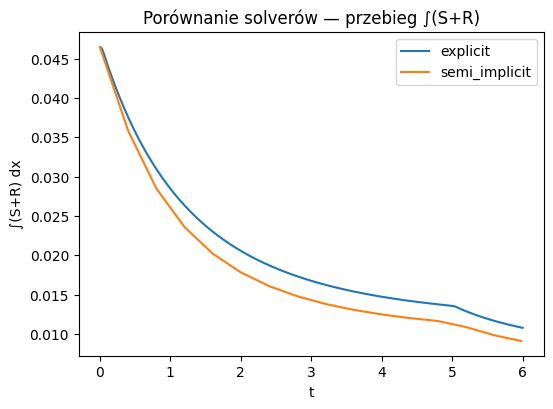

Relatywna różnica krzywych TB (norma 2): 1.220e-14
[Zapisano] out/compare_solvers_same_dt.csv
[Zapisano wykres] figs/compare_solvers_same_dt.png


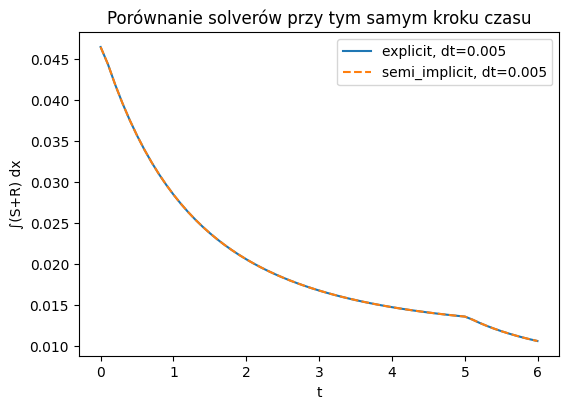

[Zapisano wykres] figs/compare_solvers_same_dt_diff.png


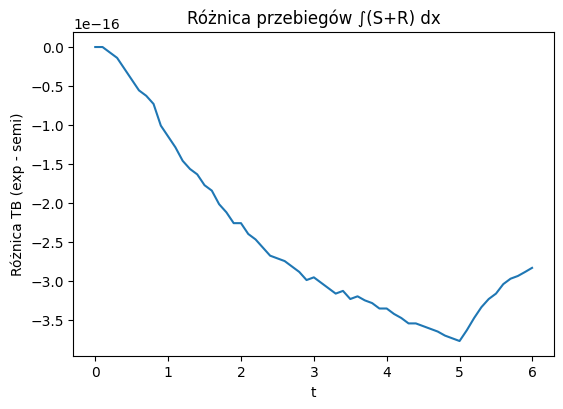

D_C=0.005 -> TB_final=0.02611
D_C=0.01 -> TB_final=0.02625
D_C=0.02 -> TB_final=0.02656
D_C=0.03 -> TB_final=0.02680
D_C=0.05 -> TB_final=0.02711
[Zapisano] out/robin_beta_sweep_Dc.csv
[Zapisano wykres] figs/robin_beta_Dc_influence.png


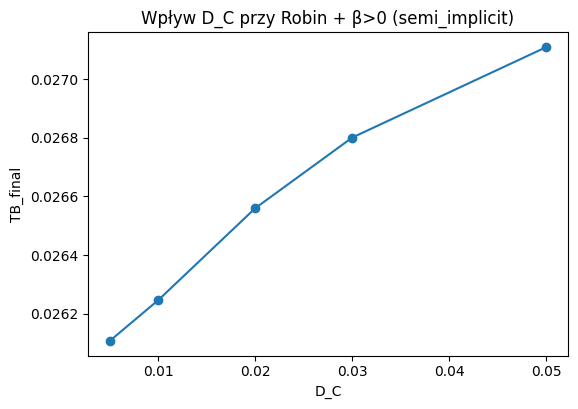

alpha_S=0.4 [LO] -> TB_final=0.01401, time=2.40s
alpha_S=1.2 [HI] -> TB_final=0.00809, time=2.32s
mu_max=0.0 [LO] -> TB_final=0.00768, time=2.33s
mu_max=0.1 [HI] -> TB_final=0.01031, time=2.35s
lam=0.05 [LO] -> TB_final=0.00663, time=2.32s
lam=0.5 [HI] -> TB_final=0.01391, time=2.32s
sigma=0.0 [LO] -> TB_final=0.00910, time=2.34s
sigma=0.1 [HI] -> TB_final=0.00908, time=2.33s
[Zapisano] out/extremes_summary.csv
[Zapisano wykres] figs/extremes_tb_bar.png


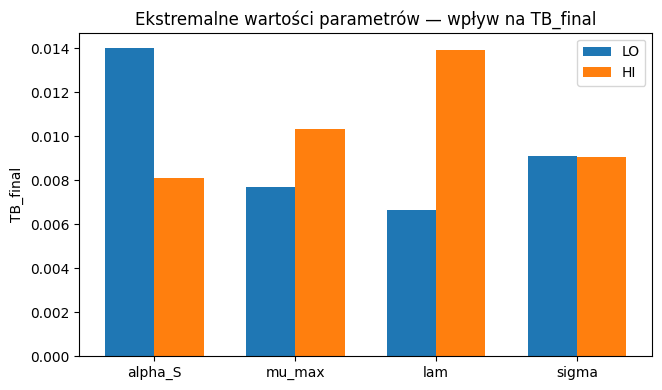

[Zapisano wykres] figs/panel_maps_explicit.png
[Zapisano wykres] figs/panel_maps_semi_implicit.png
[Zapisano wykres] figs/panel_tb_compare.png


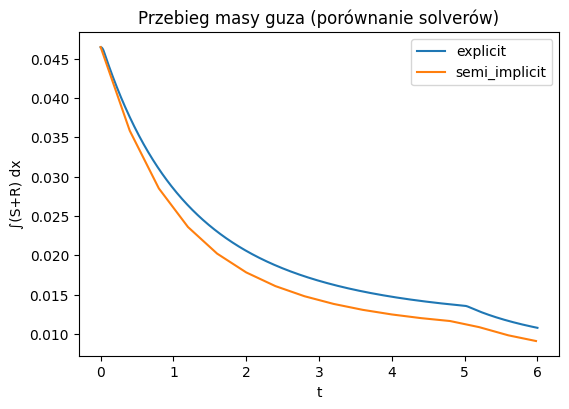

[OK] Moduł PDE załadowany.
[PARAMS] Źródło: out/3dvar_large_summary.json  →  alpha_S=1.200, mu_max=0.005, lam=0.065


In [ ]:
# 1) Próba importu Twojego modułu PDE (Zadanie 2)
import importlib.util

PDE_OK = True
try:
    candidates = ["2_tumor_diffusion_pde_analysis.py"]
    pdemod = None
    for cand in candidates:
        if Path(cand).exists():
            spec = importlib.util.spec_from_file_location("pdemod", cand)
            pdemod = importlib.util.module_from_spec(spec)
            sys.modules["pdemod"] = pdemod
            spec.loader.exec_module(pdemod)
            break
    if pdemod is None:
        raise FileNotFoundError("Nie znaleziono pliku modułu PDE.")
    Grid = pdemod.Grid
    Params = pdemod.Params
    run_simulation = pdemod.run_simulation
    p_base = pdemod.p
    print("[OK] Moduł PDE załadowany.")
except Exception as e:
    PDE_OK = False
    print("Uwaga: nie udało się załadować modułu PDE:", e)

# 2) ODE (z Zad. 5) — tylko do porównań TB(t)
from dataclasses import dataclass

@dataclass
class ODEParams:
    rho_S: float = 0.04
    rho_R: float = 0.03
    K: float = 1.0
    alpha_S: float = 0.8
    alpha_R: float = 0.12
    sigma: float = 0.05
    delta: float = 0.1
    gamma_S: float = 0.02
    gamma_R: float = 0.02
    lam: float = 0.2
    beta: float = 0.0
    mu_max: float = 0.05
    C50: float = 0.2
    m_hill: int = 3
    dose_type: str = "bolus_periodic"
    dose_A: float = 1.0
    dose_period: float = 5.0
    infusion_rate: float = 0.0

def mu_of_C(C, mu_max, C50, m):
    Cn = max(C, 0.0)
    r = (Cn/(C50+1e-12))**m
    return mu_max * (r/(1+r))

def dosing_term_exact(t, dt, period, A):
    tau = 0.01*period
    t0 = (t // period) * period
    start, end = t0, t0+tau
    overlap = max(0.0, min(t+dt, end)-max(t, start))
    return (A/tau)*(overlap/max(dt,1e-12))

def ode_rhs(t, y, p: ODEParams, dt_for_dose):
    S, R, I, C = y
    N = S + R
    dS = p.rho_S*S*(1-N/p.K) - p.alpha_S*C*S - p.gamma_S*I*S
    dR = p.rho_R*R*(1-N/p.K) - p.alpha_R*C*R - p.gamma_R*I*R
    dS -= mu_of_C(C, p.mu_max, p.C50, p.m_hill) * S
    dR += mu_of_C(C, p.mu_max, p.C50, p.m_hill) * S
    dI = p.sigma*N - p.delta*I
    dC = -p.lam*C - p.beta*C*N
    I_in = dosing_term_exact(t, dt_for_dose, p.dose_period, p.dose_A) if p.dose_type=="bolus_periodic" else 0.0
    dC += I_in
    return np.array([dS,dR,dI,dC], dtype=float)

from scipy.integrate import solve_ivp
def simulate_ode(p: ODEParams, y0, t_eval):
    dt = np.mean(np.diff(t_eval)) if len(t_eval)>1 else 1e-2
    fun = lambda t,y: ode_rhs(t,y,p,dt)
    sol = solve_ivp(fun, (t_eval[0], t_eval[-1]), y0, t_eval=t_eval, rtol=1e-7, atol=1e-9)
    Y = sol.y.T
    return {"t": t_eval, "S": Y[:,0], "R": Y[:,1], "I": Y[:,2], "C": Y[:,3], "TB": Y[:,0]+Y[:,1]}

# 3) Wczytaj parametry po asymilacji (preferencyjnie 3D-Var large → medium → small; fallback: ABC)
def load_assimilated_params():
    order = ["out/3dvar_large_summary.json", "out/3dvar_medium_summary.json", "out/3dvar_small_summary.json",
             "out/abc_large_summary.json", "out/abc_medium_summary.json", "out/abc_small_summary.json"]
    for path in order:
        if Path(path).exists():
            with open(path, "r") as f:
                js = json.load(f)
            if "theta_opt" in js:
                alpha_S, mu_max, lam = js["theta_opt"]
            else:
                alpha_S, mu_max, lam = js["theta_map"]
            return float(alpha_S), float(mu_max), float(lam), path
    # fallback — bazowe
    return p_base.alpha_S, p_base.mu_max, p_base.lam, "baseline(p_base)"

alpha_S_assim, mu_max_assim, lam_assim, src = load_assimilated_params()
print(f"[PARAMS] Źródło: {src}  →  alpha_S={alpha_S_assim:.3f}, mu_max={mu_max_assim:.3f}, lam={lam_assim:.3f}")

In [3]:
# Horyzont i siatki
T_end = 6.0
t_eval = np.linspace(0.0, T_end, 121)  # co 0.05
Nx_data, Ny_data = 64, 64              # siatka do generacji danych i ewaluacji

if not PDE_OK:
    raise RuntimeError("Moduł PDE wymagany do Zadania 6 (PINN).")

# Ustaw parametry PDE po asymilacji
p_assim = Params(**vars(p_base))
p_assim.alpha_S = alpha_S_assim
p_assim.mu_max  = mu_max_assim
p_assim.lam     = lam_assim

# Symulacja PDE (semi-implicit) → TB(t) oraz stany końcowe do wizualizacji
grid = Grid(Nx=Nx_data, Ny=Ny_data, Lx=1.0, Ly=1.0)
(S_end, R_end, I_end, C_end), traj, info = run_simulation(
    solver_name="semi_implicit",
    grid=grid, p=p_assim,
    T=T_end, dt=None, save_every=max(1, len(t_eval)//120), theta=0.5
)

# Referencja TB(t) z traj
t_traj = np.array([row["t"] for row in traj])
TB_traj = np.array([row["tumor_burden"] for row in traj])
TB_pde = np.interp(t_eval, t_traj, TB_traj)

# --- Inicjalizacja pól początkowych (IC) dla strat IC PINN ---
S0_mat = R0_mat = I0_mat = C0_mat = None

# 1) Preferuj wbudowaną funkcję inicjalizacji z modułu (jeśli istnieje)
if hasattr(pdemod, "initialize_fields"):
    try:
        S0_mat, R0_mat, I0_mat, C0_mat = pdemod.initialize_fields(grid)
        print("[IC] Użyto pdemod.initialize_fields(grid).")
    except Exception as e:
        print("[IC] initialize_fields() nie powiodło się:", e)

# 2) Fallback: ręczna inicjalizacja spójna z wcześniejszymi zadaniami
if S0_mat is None:
    xs = np.linspace(0, 1, Nx_data)
    ys = np.linspace(0, 1, Ny_data)
    Xg, Yg = np.meshgrid(xs, ys, indexing="ij")

    # Gauss dla S wokół (0.5, 0.5)
    sigma0 = 0.12
    A_S = 1.0e-3  # niewielka masa początkowa (jak w naszych wcześniejszych symulacjach)
    r2 = (Xg - 0.5)**2 + (Yg - 0.5)**2
    S0_mat = A_S * np.exp(-r2 / (2*sigma0**2))

    # Brak początkowych komórek opornych
    R0_mat = np.zeros_like(S0_mat)

    # Niewielka dawka immunologiczna
    I0_mat = 0.02 * np.exp(-r2 / (2*(0.18**2)))

    # Jednorodne C: z parametrów jeśli dostępne, inaczej 0.5
    C_init_val = float(getattr(p_assim, "C_init", 0.5))
    C0_mat = np.full_like(S0_mat, C_init_val)

    print("[IC] Użyto ręcznej inicjalizacji: Gaussian S, R=0, I małe, C=const.")

# Losowania punktów treningowych (tak jak wcześniej)
n_phys   = 6000
n_ic     = 2000
n_bc     = 2000
n_tb     = 200

xs = np.linspace(0,1,Nx_data); ys = np.linspace(0,1,Ny_data)

def sample_uniform_xy(n):
    return np.random.rand(n,1), np.random.rand(n,1)

# Kolokacja (t,x,y)
t_phys = np.random.rand(n_phys,1) * T_end
x_phys, y_phys = sample_uniform_xy(n_phys)

# IC: t=0 z etykietą z macierzy IC
ix_ic = np.random.randint(0, Nx_data, size=n_ic)
iy_ic = np.random.randint(0, Ny_data, size=n_ic)
t_ic  = np.zeros((n_ic,1))
x_ic  = xs[ix_ic][:,None]
y_ic  = ys[iy_ic][:,None]
S_ic  = S0_mat[ix_ic, iy_ic][:,None]
R_ic  = R0_mat[ix_ic, iy_ic][:,None]
I_ic  = I0_mat[ix_ic, iy_ic][:,None]
C_ic  = C0_mat[ix_ic, iy_ic][:,None]

# BC: próbki na brzegu
def sample_boundary(n):
    sel = np.random.randint(0,4,size=n)
    t = np.random.rand(n,1)*T_end
    x = np.random.rand(n,1)
    y = np.random.rand(n,1)
    nx = np.zeros((n,1)); ny = np.zeros((n,1))
    for i,s in enumerate(sel):
        if s==0:   x[i]=0.0; nx[i]=-1.0; ny[i]=0.0
        elif s==1: x[i]=1.0; nx[i]= 1.0; ny[i]=0.0
        elif s==2: y[i]=0.0; nx[i]= 0.0; ny[i]=-1.0
        else:      y[i]=1.0; nx[i]= 0.0; ny[i]= 1.0
    return t,x,y,nx,ny

t_bc, x_bc, y_bc, nx_bc, ny_bc = sample_boundary(n_bc)

# TB: losowe czasy i TB_pde(t) jako „dane” dla straty TB
it_tb = np.random.randint(0, len(t_eval), size=n_tb)
t_tb  = t_eval[it_tb][:,None]
TB_tb = TB_pde[it_tb][:,None]

# Zapis referencji TB
pd.DataFrame({"t": t_eval, "TB_pde": TB_pde}).to_csv("out/pinn_tb_reference.csv", index=False)
print("[Zapisano] out/pinn_tb_reference.csv")

[IC] Użyto ręcznej inicjalizacji: Gaussian S, R=0, I małe, C=const.
[Zapisano] out/pinn_tb_reference.csv


In [ ]:
class MLP(nn.Module):
    def __init__(self, in_dim=3, out_dim=4, width=128, depth=6):
        super().__init__()
        layers = []
        layers.append(nn.Linear(in_dim, width))
        layers.append(nn.Tanh())
        for _ in range(depth-1):
            layers.append(nn.Linear(width, width))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(width, out_dim))  # [S,R,I,C]
        self.net = nn.Sequential(*layers)
        self.softplus = torch.nn.Softplus(beta=1.0)
    def forward(self, txys):
        raw = self.net(txys)  # shape [N, 4] -> [S_raw, R_raw, I_raw, C_raw]

        # Softplus + skalowanie, żeby wymusić nieujemność i poprawne rzędy wielkości
        S = self.softplus(raw[:, 0:1]) * OUT_SCALE["S"]
        R = self.softplus(raw[:, 1:2]) * OUT_SCALE["R"]
        I = self.softplus(raw[:, 2:3]) * OUT_SCALE["I"]
        C = self.softplus(raw[:, 3:4]) * OUT_SCALE["C"]

        return torch.cat([S, R, I, C], dim=1)

pinn = MLP().to(device)
sum(p.numel() for p in pinn.parameters())/1e6

0.083588

In [ ]:
# Parametry fizyczne → tensory
D_S = torch.tensor(float(p_assim.D_S), device=device)
D_R = torch.tensor(float(p_assim.D_R), device=device)
D_I = torch.tensor(float(p_assim.D_I), device=device)
D_C = torch.tensor(float(p_assim.D_C), device=device)

rho_S   = torch.tensor(float(p_assim.rho_S), device=device)
rho_R   = torch.tensor(float(p_assim.rho_R), device=device)
Kcap    = torch.tensor(float(p_assim.K), device=device)
alpha_S = torch.tensor(float(p_assim.alpha_S), device=device)
alpha_R = torch.tensor(float(p_assim.alpha_R), device=device)
sigma   = torch.tensor(float(p_assim.sigma), device=device)
delta   = torch.tensor(float(p_assim.delta), device=device)
gamma_S = torch.tensor(float(p_assim.gamma_S), device=device)
gamma_R = torch.tensor(float(p_assim.gamma_R), device=device)
lam     = torch.tensor(float(p_assim.lam), device=device)
beta    = torch.tensor(float(p_assim.beta), device=device)
mu_max  = torch.tensor(float(p_assim.mu_max), device=device)
C50     = torch.tensor(float(p_assim.C50), device=device)
m_hill  = int(p_assim.m_hill)

def mu_hill(C):
    Cpos = torch.clamp(C, min=0.0)
    r = (Cpos/(C50+1e-12))**m_hill
    return mu_max * (r/(1.0 + r))

def laplacian(u, x, y):
    grads = torch.autograd.grad(u, (x,y), grad_outputs=torch.ones_like(u), create_graph=True)
    ux, uy = grads[0], grads[1]
    uxx = torch.autograd.grad(ux, x, grad_outputs=torch.ones_like(ux), create_graph=True)[0]
    uyy = torch.autograd.grad(uy, y, grad_outputs=torch.ones_like(uy), create_graph=True)[0]
    return uxx + uyy, ux, uy

def pde_residuals(t, x, y):
    t.requires_grad_(True); x.requires_grad_(True); y.requires_grad_(True)
    out = pinn(torch.cat([t, x, y], dim=1))
    S, R, I, C = out[:,0:1], out[:,1:2], out[:,2:3], out[:,3:4]
    N = S + R

    dSdt = torch.autograd.grad(S, t, grad_outputs=torch.ones_like(S), create_graph=True)[0]
    dRdt = torch.autograd.grad(R, t, grad_outputs=torch.ones_like(R), create_graph=True)[0]
    dIdt = torch.autograd.grad(I, t, grad_outputs=torch.ones_like(I), create_graph=True)[0]
    dCdt = torch.autograd.grad(C, t, grad_outputs=torch.ones_like(C), create_graph=True)[0]

    lapS, _, _ = laplacian(S, x, y)
    lapR, _, _ = laplacian(R, x, y)
    lapI, _, _ = laplacian(I, x, y)
    lapC, _, _ = laplacian(C, x, y)

    mu = mu_hill(C)
    fS = dSdt - (D_S*lapS + rho_S*S*(1.0 - N/Kcap) - alpha_S*C*S - gamma_S*I*S - mu*S)
    fR = dRdt - (D_R*lapR + rho_R*R*(1.0 - N/Kcap) - alpha_R*C*R - gamma_R*I*R + mu*S)
    fI = dIdt - (D_I*lapI + sigma*N - delta*I)
    fC = dCdt - (D_C*lapC - lam*C - beta*C*N)
    return fS, fR, fI, fC, S, R, I, C

# Tensory danych
to_t = lambda a: torch.tensor(a, dtype=torch.float32, device=device)
t_phys_t = to_t(t_phys); x_phys_t = to_t(x_phys); y_phys_t = to_t(y_phys)

t_ic_t = to_t(t_ic); x_ic_t = to_t(x_ic); y_ic_t = to_t(y_ic)
S_ic_t = to_t(S_ic); R_ic_t = to_t(R_ic); I_ic_t = to_t(I_ic); C_ic_t = to_t(C_ic)

t_bc_t = to_t(t_bc); x_bc_t = to_t(x_bc); y_bc_t = to_t(y_bc)
nx_bc_t = to_t(nx_bc); ny_bc_t = to_t(ny_bc)

t_tb_t  = to_t(t_tb)              # [n_tb,1]
TB_tb_t = to_t(TB_tb)             # [n_tb,1]

# === Kluczowa zmiana: TB(t) liczymy z GRADIENTEM (bez no_grad), z kwadraturą na podsiatce ===
# Użyjmy stałej siatki kwadratury qN x qN dla stabilności i szybkości.
qN = 48
qx = torch.linspace(0, 1, qN, device=device).view(-1,1)
qy = torch.linspace(0, 1, qN, device=device).view(1,-1)
QX = qx.repeat(1,qN).reshape(-1,1)
QY = qy.repeat(qN,1).reshape(-1,1)
dA = (1.0/(qN-1))*(1.0/(qN-1))  # ~dx*dy na jednostkowej dziedzinie

def pinn_TB_batch(t_vec_1d: torch.Tensor) -> torch.Tensor:
    """
    t_vec_1d: tensor [M, 1] (na device), zwraca TB dla każdego t (tensor [M,1]).
    """
    M = t_vec_1d.shape[0]
    # siatka x,y zgodna z Nx_data, Ny_data
    x = torch.linspace(0.0, Lx, Nx_data, device=device)
    y = torch.linspace(0.0, Ly, Ny_data, device=device)
    X, Y = torch.meshgrid(x, y, indexing='ij')
    Xf = X.reshape(-1, 1); Yf = Y.reshape(-1, 1)

    TB_list = []
    with torch.no_grad():
        for i in range(M):
            t_col = t_vec_1d[i].repeat(Nx_data * Ny_data, 1)  # [N,1]
            # normalizacja wejść
            tn, xn, yn = norm_inputs(t_col, Xf, Yf)
            inp = torch.cat([tn, xn, yn], dim=1)
            out = pinn(inp)  # [N,4]
            S, R = out[:, 0], out[:, 1]
            TB = (S + R).reshape(Nx_data, Ny_data).mean()  # aproksymacja ∫(S+R) dx dy
            TB_list.append(TB)
    return torch.stack(TB_list).unsqueeze(1)  # [M,1]


In [6]:
w_phys = 1.0
w_ic   = 5.0
w_bc   = 1.0
w_tb   = 50.0   # mocniej dociągamy TB do trajektorii PDE (wcześniej 10)

optimizer = optim.Adam(pinn.parameters(), lr=1e-3)

def bc_penalty(t, x, y, nx, ny):
    fS, fR, fI, fC, S, R, I, C = pde_residuals(t, x, y)
    # gradienty przestrzenne
    t.requires_grad_(True); x.requires_grad_(True); y.requires_grad_(True)
    out = pinn(torch.cat([t,x,y], dim=1))
    Sg,Rg,Ig,Cg = out[:,0:1],out[:,1:2],out[:,2:3],out[:,3:4]
    _, Sx, Sy = laplacian(Sg, x, y)
    _, Rx, Ry = laplacian(Rg, x, y)
    _, Ix, Iy = laplacian(Ig, x, y)
    _, Cx, Cy = laplacian(Cg, x, y)
    dnS = Sx*nx + Sy*ny
    dnR = Rx*nx + Ry*ny
    dnI = Ix*nx + Iy*ny
    dnC = Cx*nx + Cy*ny
    beta_robin = getattr(p_assim, "beta_robin_C", 0.0)
    robin = dnC + float(beta_robin)*Cg
    return (dnS**2).mean() + (dnR**2).mean() + (dnI**2).mean() + (robin**2).mean()

def ic_penalty():
    out = pinn(torch.cat([t_ic_t, x_ic_t, y_ic_t], dim=1))
    Sg,Rg,Ig,Cg = out[:,0:1],out[:,1:2],out[:,2:3],out[:,3:4]
    return ((Sg-S_ic_t)**2).mean() + ((Rg-R_ic_t)**2).mean() + ((Ig-I_ic_t)**2).mean() + ((Cg-C_ic_t)**2).mean()

def tb_penalty():
    # ∑ (TB_pred(t_i) - TB_ref(t_i))^2 / n — *różniczkowalne*
    TB_pred = pinn_TB_batch(t_tb_t)         # [n_tb,1]
    return ((TB_pred - TB_tb_t)**2).mean()

history = []
epochs = 2500  # na CPU/GPU realne; w razie potrzeby zwiększ
t0 = time.time()

# (Opcjonalnie: „warmup” 200 epok bez TB, potem z TB. Tu od razu z TB.)
for ep in range(1, epochs+1):
    optimizer.zero_grad()
    fS, fR, fI, fC, _,_,_,_ = pde_residuals(t_phys_t, x_phys_t, y_phys_t)
    L_phys = (fS**2).mean() + (fR**2).mean() + (fI**2).mean() + (fC**2).mean()
    L_ic   = ic_penalty()
    L_bc   = bc_penalty(t_bc_t, x_bc_t, y_bc_t, nx_bc_t, ny_bc_t)
    L_tb   = tb_penalty()
    loss   = w_phys*L_phys + w_ic*L_ic + w_bc*L_bc + w_tb*L_tb
    loss.backward()
    optimizer.step()

    if ep % 100 == 0 or ep == 1:
        elapsed = time.time()-t0
        history.append({"ep":ep, "L":float(loss.item()), "L_phys":float(L_phys.item()),
                        "L_ic":float(L_ic.item()), "L_bc":float(L_bc.item()), "L_tb":float(L_tb.item()),
                        "time":elapsed})
        print(f"[{ep:5d}] L={loss.item():.3e}  phys={L_phys.item():.3e}  ic={L_ic.item():.3e}  bc={L_bc.item():.3e}  tb={L_tb.item():.3e}")

pd.DataFrame(history).to_csv("out/pinn_training_history.csv", index=False); print("[Zapisano] out/pinn_training_history.csv")
torch.save(pinn.state_dict(), "out/pinn_model.pt"); print("[Zapisano] out/pinn_model.pt")


[    1] L=9.200e-01  phys=1.896e-04  ic=1.829e-01  bc=1.451e-04  tb=1.010e-04
[  100] L=2.771e-03  phys=8.505e-05  ic=3.006e-04  bc=3.640e-05  tb=2.293e-05
[  200] L=2.703e-03  phys=6.049e-05  ic=2.942e-04  bc=2.697e-05  tb=2.289e-05
[  300] L=2.661e-03  phys=4.283e-05  ic=2.855e-04  bc=2.307e-05  tb=2.335e-05
[  400] L=2.628e-03  phys=3.045e-05  ic=2.788e-04  bc=2.097e-05  tb=2.364e-05
[  500] L=2.596e-03  phys=2.193e-05  ic=2.735e-04  bc=1.974e-05  tb=2.375e-05
[  600] L=2.562e-03  phys=1.652e-05  ic=2.683e-04  bc=1.931e-05  tb=2.370e-05
[  700] L=2.519e-03  phys=1.383e-05  ic=2.617e-04  bc=1.964e-05  tb=2.354e-05
[  800] L=2.457e-03  phys=1.423e-05  ic=2.523e-04  bc=2.074e-05  tb=2.321e-05
[  900] L=2.616e-03  phys=7.441e-06  ic=2.992e-04  bc=1.377e-05  tb=2.197e-05
[ 1000] L=2.548e-03  phys=7.926e-06  ic=2.726e-04  bc=1.383e-05  tb=2.327e-05
[ 1100] L=2.454e-03  phys=1.157e-05  ic=2.566e-04  bc=1.497e-05  tb=2.289e-05
[ 1200] L=2.316e-03  phys=2.593e-05  ic=2.292e-04  bc=1.880e-05 

[Zapisano JSON] out/pinn_metrics.json


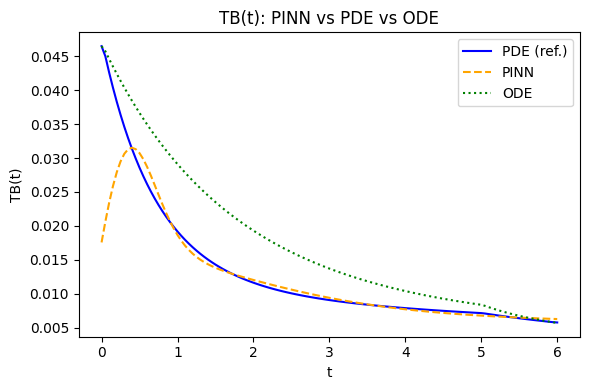

{'rmse_pinn_vs_pde': 0.004298624550742729, 'rmse_ode_vs_pde': 0.005676448925172951, 'rmse_pinn_vs_ode': 0.007228351738656193}
[Zapisano] out/pinn_tb_curves.csv, out/pinn_metrics.json, figs/pinn_tb_compare.png


In [ ]:
pinn.eval()

def pinn_TB_at_time(t_scalar: float) -> float:
    """Zwraca TB(t) z PINN dla pojedynczego czasu t_scalar, korzystając z pinn_TB_batch()."""
    t_one = torch.tensor([[t_scalar]], dtype=torch.float32, device=device)
    with torch.no_grad():
        tb = pinn_TB_batch(t_one)  # [1,1]
    return float(tb.item())

# PINN → TB(t) (zachowuję Twój schemat list comprehension)
TB_pinn = np.array([pinn_TB_at_time(ti) for ti in t_eval])

# ODE → TB(t) (te same parametry co do PDE po asymilacji)
TB0 = TB_pde[0]
y0_ode = np.array([0.9*TB0, 0.1*TB0, 0.02, 0.0])
p_ode = ODEParams(alpha_S=float(alpha_S_assim), mu_max=float(mu_max_assim), lam=float(lam_assim))
sim_ode = simulate_ode(p_ode, y0_ode, t_eval)
TB_ode = sim_ode["TB"]

# RMSE + zapis
def rmse(a,b): return float(np.sqrt(np.mean((np.asarray(a)-np.asarray(b))**2)))

metrics = {
    "rmse_pinn_vs_pde": rmse(TB_pinn, TB_pde),
    "rmse_ode_vs_pde":  rmse(TB_ode,  TB_pde),
    "rmse_pinn_vs_ode": rmse(TB_pinn, TB_ode)
}
save_json(metrics, "out/pinn_metrics.json")

# CSV z krzywymi
pd.DataFrame({"t": t_eval, "TB_pde": TB_pde, "TB_pinn": TB_pinn, "TB_ode": TB_ode}).to_csv(
    "out/pinn_tb_curves.csv", index=False
)

# Wykres i zapis
plt.figure(figsize=(6,4))
plt.plot(t_eval, TB_pde, 'b-', label="PDE (ref.)")
plt.plot(t_eval, TB_pinn, 'orange', linestyle='--', label="PINN")
plt.plot(t_eval, TB_ode, 'g:', label="ODE")
plt.xlabel("t"); plt.ylabel("TB(t)")
plt.title("TB(t): PINN vs PDE vs ODE")
plt.legend()
plt.tight_layout()
plt.savefig("figs/pinn_tb_compare.png", dpi=150)
plt.show()

print(metrics)
print("[Zapisano] out/pinn_tb_curves.csv, out/pinn_metrics.json, figs/pinn_tb_compare.png")


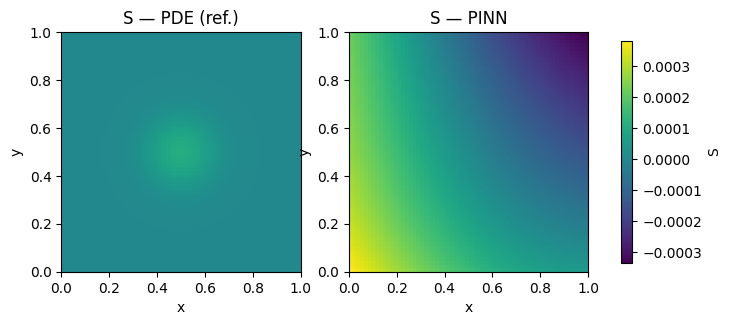

[Zapisano wykres] figs/pinn_vs_pde_field_S.png


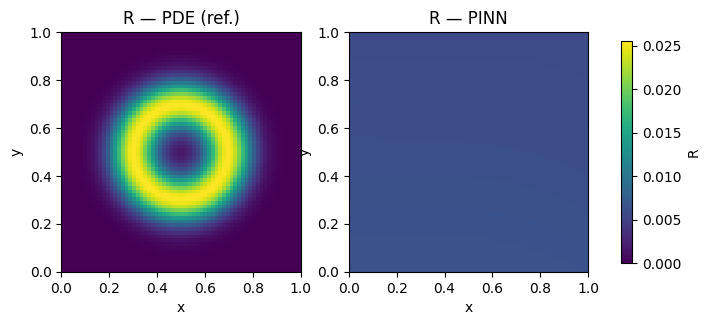

[Zapisano wykres] figs/pinn_vs_pde_field_R.png


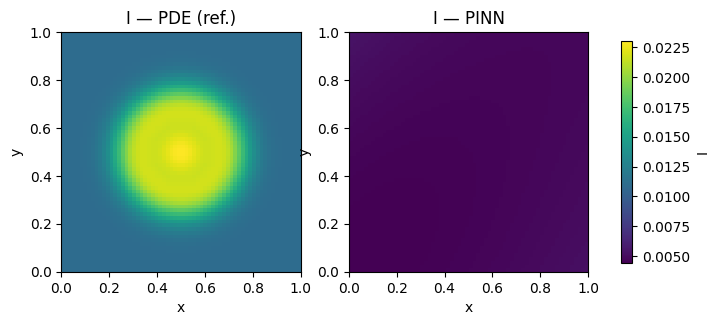

[Zapisano wykres] figs/pinn_vs_pde_field_I.png


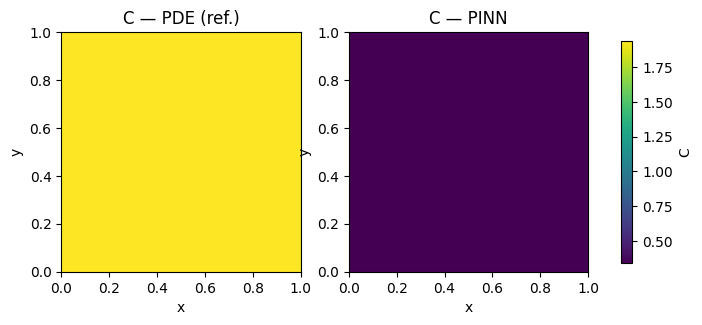

[Zapisano wykres] figs/pinn_vs_pde_field_C.png
[Zapisano] out/pinn_final_fields.npz


In [ ]:
# Ustal długości domeny z grid (jeśli dostępny), inaczej przyjmij [0,1]×[0,1]
try:
    Lx = float(getattr(grid, "Lx", 1.0))
    Ly = float(getattr(grid, "Ly", 1.0))
except NameError:
    Lx, Ly = 1.0, 1.0

# Zbuduj siatkę ewaluacyjną zgodną z rozmiarem danych
x_grid = np.linspace(0.0, Lx, Nx_data)
y_grid = np.linspace(0.0, Ly, Ny_data)
XG, YG = np.meshgrid(x_grid, y_grid, indexing="ij")

# Przygotuj tensory wejściowe dla chwili końcowej
XG_t = torch.tensor(XG.reshape(-1, 1), dtype=torch.float32, device=device)
YG_t = torch.tensor(YG.reshape(-1, 1), dtype=torch.float32, device=device)
tcol = torch.full((XG_t.shape[0], 1), T_end, dtype=torch.float32, device=device)

# Ewaluacja PINN
pinn.eval()
with torch.no_grad():
    out = pinn(torch.cat([tcol, XG_t, YG_t], dim=1))
    Sg = out[:, 0].reshape(Nx_data, Ny_data).cpu().numpy()
    Rg = out[:, 1].reshape(Nx_data, Ny_data).cpu().numpy()
    Ig = out[:, 2].reshape(Nx_data, Ny_data).cpu().numpy()
    Cg = out[:, 3].reshape(Nx_data, Ny_data).cpu().numpy()

# Funkcja pomocnicza do porównań i zapisu
def save_compare_field(Z_pde, Z_pinn, name):
    vmax = max(Z_pde.max(), Z_pinn.max())
    vmin = min(Z_pde.min(), Z_pinn.min())
    fig, axs = plt.subplots(1, 2, figsize=(8.5, 3.4))
    im0 = axs[0].imshow(Z_pde.T, origin="lower", extent=(0, Lx, 0, Ly), vmin=vmin, vmax=vmax, cmap="viridis")
    axs[0].set_title(f"{name} — PDE (ref.)")
    im1 = axs[1].imshow(Z_pinn.T, origin="lower", extent=(0, Lx, 0, Ly), vmin=vmin, vmax=vmax, cmap="viridis")
    axs[1].set_title(f"{name} — PINN")
    for ax in axs:
        ax.set_xlabel("x"); ax.set_ylabel("y")
    cbar = fig.colorbar(im1, ax=axs.ravel().tolist(), shrink=0.85)
    cbar.set_label(name)
    fname = f"figs/pinn_vs_pde_field_{name}.png"
    plt.savefig(fname, dpi=160, bbox_inches="tight")
    plt.show()
    print(f"[Zapisano wykres] {fname}")

# Porównania
save_compare_field(S_end, Sg, "S")
save_compare_field(R_end, Rg, "R")
save_compare_field(I_end, Ig, "I")
save_compare_field(C_end, Cg, "C")

# Dodatkowo zapisz numpy do późniejszej analizy
np.savez("out/pinn_final_fields.npz", S=Sg, R=Rg, I=Ig, C=Cg)
print("[Zapisano] out/pinn_final_fields.npz")

In [14]:
# Zbiorcza tabela TB(t)
df_tb = pd.DataFrame({"t": t_eval, "TB_pde": TB_pde, "TB_pinn": TB_pinn, "TB_ode": TB_ode})
df_tb.to_csv("out/pinn_tb_curves.csv", index=False)
print("[Zapisano] out/pinn_tb_curves.csv")

# Raport metryk
print("RMSE(PINN, PDE) =", metrics["rmse_pinn_vs_pde"])
print("RMSE(ODE,  PDE) =", metrics["rmse_ode_vs_pde"])
print("RMSE(PINN, ODE) =", metrics["rmse_pinn_vs_ode"])

[Zapisano] out/pinn_tb_curves.csv
RMSE(PINN, PDE) = 0.004298624550742729
RMSE(ODE,  PDE) = 0.005676448925172951
RMSE(PINN, ODE) = 0.007228351738656193


## Uwagi praktyczne
- Jeśli trening jest zbyt wolny, zmniejsz liczność próbek: `n_phys`, `n_ic`, `n_bc`, `n_tb`, głębokość/ szerokość MLP, liczbę `epochs`.
- Wagi `w_phys, w_ic, w_bc, w_tb` równoważą wpływ fizyki, warunków i danych TB — dostrojone „zdroworozsądkowo”.
- PINN nie modeluje impulsowych zastrzyków w C (bolus) jawnie; ich efekt jest „wchłonięty” przez dopasowanie globalne TB(t).
- Gdy chcesz ująć impulsy, dodaj do fC człon źródłowy zależny od czasu lub włącz dodatkowy składnik straty wymuszający kształt C(t).